In [0]:

import sys

import numpy as np
import matplotlib.pyplot as plt


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
def apply_transforms(image, size=28):
    """Transforms a PIL image to torch.Tensor.
    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.
    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.
    The plan is to to expand this to handle custom size/mean/std.
    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor
    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`
    Returns:
        torch.Tensor (torch.float32): Transformed image tensor
    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image
    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        # transforms.Normalize(means, stds)
    ])
    tensor = transform(image).unsqueeze(0)
    tensor.requires_grad = True

    return tensor


def denormalize(tensor):
    """Reverses the normalisation on a tensor.
    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.
    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean
    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor
    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)
    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]
    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image
    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0,
                         saturation=0.1, brightness=0.5):

    """Standardizes and clips input tensor.
    Standardizes the input tensor (mean = 0.0, std = 1.0). The color saturation
    and brightness are adjusted, before tensor values are clipped to min/max
    (default: 0.0/1.0).
    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)
        saturation (float, optional, default=0.1)
        brightness (float, optional, default=0.5)
    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input
    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]
    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()

    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(saturation)
    clipped = standardized.add(brightness).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.
    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.
    Args:
        tensor (torch.Tensor, torch.float32): Image tensor
    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively
    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)
    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image
    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()

In [0]:
class GradientAscent:
    """Provides an interface for activation maximization via gradient descent.
    This class implements the gradient ascent algorithm in order to perform
    activation maximization with convolutional neural networks (CNN).
    `Activation maximization <https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf>`_
    is one form of feature visualization that allows us to visualize what CNN
    filters are "looking for", by applying each filter to an input image and
    updating the input image so as to maximize the activation of the filter of
    interest (i.e. treating it as a gradient ascent task with activation as the
    loss). The implementation is inspired by `this demo <https://blog.keras.io/category/demo.html>`_
    by Francois Chollet.
    Args:
        model: A neural network model from `torchvision.models
            <https://pytorch.org/docs/stable/torchvision/models.html>`_,
            typically without the fully-connected part of the network.
            e.g. torchvisions.alexnet(pretrained=True).features
        img_size (int, optional, default=224): The size of an input image to be
            optimized.
        lr (float, optional, default=1.): The step size (or learning rate) of
            the gradient ascent.
        use_gpu (bool, optional, default=False): Use GPU if set to True and
            `torch.cuda.is_available()`.
    """

    ####################
    # Public interface #
    ####################

    def __init__(self, model, img_size=28, lr=1., use_gpu=False):
        self.model = model
        self._img_size = img_size
        self._lr = lr
        self._use_gpu = use_gpu

        self.num_layers = len(list(self.model.named_children()))
        self.activation = None
        self.gradients = None

        self.handlers = []

        self.output = None

    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr

    @property
    def img_size(self):
        return self._img_size

    @img_size.setter
    def img_size(self, img_size):
        self._img_size = img_size

    @property
    def use_gpu(self):
        return self._use_gpu

    @use_gpu.setter
    def use_gpu(self, use_gpu):
        self._use_gpu = use_gpu

    def optimize(self, layer, filter_idx, input_=None, num_iter=30):
        """Generates an image that maximally activates the target filter.
        Args:
            layer (torch.nn.modules.conv.Conv2d): The target Conv2d layer from
                which the filter to be chosen, based on `filter_idx`.
            filter_idx (int): The index of the target filter.
            num_iter (int, optional, default=30): The number of iteration for
                the gradient ascent operation.
        Returns:
            output (list of torch.Tensor): With dimentions
                :math:`(num_iter, C, H, W)`. The size of the image is
                determined by `img_size` attribute which defaults to 224.
        """

        # Validate the type of the layer

        if type(layer) != nn.modules.conv.Conv2d:
            raise TypeError('The layer must be nn.modules.conv.Conv2d.')

        # Validate filter index

        num_total_filters = layer.out_channels
        self._validate_filter_idx(num_total_filters, filter_idx)

        # Inisialize input (as noise) if not provided

        if input_ is None:
            input_ = np.uint8(np.random.uniform(
                150, 180, (self._img_size, self._img_size, 1)))
            input_ = apply_transforms(input_, size=self._img_size)

        if torch.cuda.is_available() and self.use_gpu:
            self.model = self.model.to('cuda')
            input_ = input_.to('cuda')

        # Remove previous hooks if any

        while len(self.handlers) > 0:
            self.handlers.pop().remove()

        # Register hooks to record activation and gradients

        self.handlers.append(self._register_forward_hooks(layer, filter_idx))
        self.handlers.append(self._register_backward_hooks())

        # Inisialize gradients

        self.gradients = torch.zeros(input_.shape)

        # Optimize

        return self._ascent(input_, num_iter)

    def visualize(self, layer, filter_idxs=None, lr=1., num_iter=30,
                  num_subplots=4, figsize=(4, 4), title='Conv2d',
                  return_output=False):
        """Optimizes for the target layer/filter and visualizes the output.
        A method that combines optimization and visualization. There are
        mainly 3 types of operations, given a target layer:
        1. If `filter_idxs` is provided as an integer, it optimizes for the
            filter specified and plots the output.
        2. If `filter_idxs` is provided as a list of integers, it optimizes for
            all the filters specified and plots the output.
        3. if `filter_idx` is not provided, i.e. None, it randomly chooses
            `num_subplots` number of filters from the layer provided and
            plots the output.
        It also returns the output of the optimization, if specified with
        `return_output=True`.
        Args:
            layer (torch.nn.modules.conv.Conv2d): The target Conv2d layer from
                which the filter to be chosen, based on `filter_idx`.
            filter_idxs (int or list of int, optional, default=None): The index
                or indecies of the target filter(s).
            lr (float, optional, default=.1): The step size of optimization.
            num_iter (int, optional, default=30): The number of iteration for
                the gradient ascent operation.
            num_subplots (int, optional, default=4): The number of filters to
                optimize for and visualize. Relevant in case 3 above.
            figsize (tuple, optional, default=(4, 4)): The size of the plot.
                Relevant in case 1 above.
            title (str, optional default='Conv2d'): The title of the plot.
            return_output (bool, optional, default=False): Returns the
                output(s) of optimization if set to True.
        Returns:
            For a single optimization (i.e. case 1 above):
                output (list of torch.Tensor): With dimentions
                    :math:`(num_iter, C, H, W)`. The size of the image is
                    determined by `img_size` attribute which defaults to 224.
            For multiple optimization (i.e. case 2 or 3 above):
                output (list of list of torch.Tensor): With dimentions
                    :math:`(num_subplots, num_iter, C, H, W)`. The size of the
                    image is determined by `img_size` attribute which defaults
                    to 224.
        """

        self._lr = lr

        if (type(filter_idxs) == int):
            output = self._visualize_filter(layer,
                                            filter_idxs,
                                            num_iter=num_iter,
                                            figsize=figsize,
                                            title=title)
        else:
            num_total_filters = layer.out_channels

            if filter_idxs is None:
                num_subplots = min(num_total_filters, num_subplots)
                filter_idxs = np.random.choice(range(num_total_filters),
                                               size=num_subplots)

            self._visualize_filters(layer,
                                    filter_idxs,
                                    num_iter,
                                    len(filter_idxs),
                                    title=title)

        if return_output:
            return self.output

   

    def _register_forward_hooks(self, layer, filter_idx):
        def _record_activation(module, input_, output):
            self.activation = torch.mean(output[:,filter_idx,:,:])

        return layer.register_forward_hook(_record_activation)

    def _register_backward_hooks(self):
        def _record_gradients(module, grad_in, grad_out):
            if self.gradients.shape == grad_in[0].shape:
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and \
                    module.in_channels == 1:
                return module.register_backward_hook(_record_gradients)

    def _ascent(self, x, num_iter):
        output = []

        for i in range(num_iter):
            self.model(x)

            self.activation.backward()

            self.gradients /= (torch.sqrt(torch.mean(
                torch.mul(self.gradients, self.gradients))) + 1e-5)

            x = x + self.gradients * self._lr
            output.append(x)

        return output

    def _validate_filter_idx(self, num_filters, filter_idx):
        if not np.issubdtype(type(filter_idx), np.integer):
            raise TypeError('Indecies must be integers.')
        elif (filter_idx < 0) or (filter_idx > num_filters):
            raise ValueError(f'Filter index must be between 0 and {num_filters - 1}.')

    def _visualize_filter(self, layer, filter_idx, num_iter, figsize, title):
        self.output = self.optimize(layer, filter_idx, num_iter=num_iter)

        plt.figure(figsize=figsize)
        plt.axis('off')
        plt.title(title)

        plt.imshow(format_for_plotting(
            standardize_and_clip(self.output[-1],
                                 saturation=0.15,
                                 brightness=0.7)));

    def _visualize_filters(self, layer, filter_idxs, num_iter, num_subplots,
                           title):
        # Prepare the main plot

        num_cols = 4
        num_rows = int(np.ceil(num_subplots / num_cols))

        fig = plt.figure(figsize=(16, num_rows * 5))
        plt.title(title)
        plt.axis('off')

        self.output = []

        # Plot subplots

        for i, filter_idx in enumerate(filter_idxs):
            output = self.optimize(layer, filter_idx, num_iter=num_iter)

            self.output.append(output)

            ax = fig.add_subplot(num_rows, num_cols, i+1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'filter {filter_idx}')

            ax.imshow(format_for_plotting(
                standardize_and_clip(output[-1],
                                     saturation=0.15,
                                     brightness=0.7)))

        plt.subplots_adjust(wspace=0, hspace=0);
            

In [5]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_binary_V2')

In [7]:
from torch.cuda import is_available
import torch.optim as optim
from DataLoader.dataLoaders import get_mnist_dataloaders
from utils.training import training, test, gpu_config
from torch import load
from visualize.viz import visTensor, visualize_activations
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torchvision

from utils.models import BinaryNet, NoBinaryNetMnist

import seaborn as sns

import numpy as np

from PIL import Image

from visualize.viz import visTensor, get_activation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import torchvision.transforms.functional as F

In [0]:
# parameters default values
lr = 0.1
momentum = 0.9
nb_epoch = 10
batch_size_train = 64
batch_size_test = 1000
batch_size = 1
slope_annealing = False
reinforce = False
stochastic = True
binary = True
plot_result = True
first_conv_layer = False
last_conv_layer = False
omniglto = True

In [0]:
train_data = datasets.MNIST('./data', train=True, download=True,
                                            
                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize((0.1307,),
                                                                                                (0.3081,))]))

In [0]:
# Model, activation type, estimator type
def get_my_model(binary, stochastic, reinforce, first_conv_layer,
                 last_conv_layer):

    if binary:
        if stochastic:
            mode = 'Stochastic'
            names_model = 'Stochastic'
        else:
          
            mode = 'Deterministic'
            names_model = 'Deterministic'
        if reinforce:
            estimator = 'REINFORCE'
            names_model += '_REINFORCE'
        else:
            estimator = 'ST'
            names_model += '_ST'
        if first_conv_layer:
            names_model += '_first_conv_binary'
        if last_conv_layer:
            names_model += '_last_conv_binary'
        model = BinaryNet(first_conv_layer=first_conv_layer, 
                          last_conv_layer=last_conv_layer, mode=mode, 
                          estimator=estimator)
    else:
        model = NoBinaryNetMnist()
        names_model = 'NonBinaryNet'
        mode = None
        estimator = None

    # gpu config:
    model, use_gpu = gpu_config(model)
    return model, names_model

In [12]:
# parameters model to load
# parameters no binary model
slope_annealing = False
stochastic = False
reinforce = False
binary = False
plot_result = False
first_conv_layer = False
last_conv_layer = False

use_gpu = False

# Slope annealing
if slope_annealing:
    def get_slope(number_epoch): return 1.0 * (1.005 ** (number_epoch - 1))
else:
    def get_slope(number_epoch): return 1.0
    
model, name_model = get_my_model(binary, stochastic, reinforce, 
                                  first_conv_layer, last_conv_layer)
# print(model)

# load model
if not use_gpu:
  model.load_state_dict(load('./trained_models/MNIST/' + name_model + '.pt', map_location=torch.device('cpu')))
else:
  model.load_state_dict(load('./trained_models/MNIST/' + name_model + '.pt'))

print(name_model, ' loaded')

use 1 gpu who named: Tesla P100-PCIE-16GB
NonBinaryNet  loaded


In [13]:
list(model.named_children())

[('layer1', Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )), ('act_layer1', Hardsigmoid(
    (act): Hardtanh(min_val=-1.0, max_val=1.0)
  )), ('layer2', Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )), ('act_layer2', Hardsigmoid(
    (act): Hardtanh(min_val=-1.0, max_val=1.0)
  )), ('fc', Linear(in_features=1568, out_features=10, bias=True))]

In [0]:
g_ascent = GradientAscent(model.layer2)

g_ascent.use_gpu = True

RuntimeError: ignored

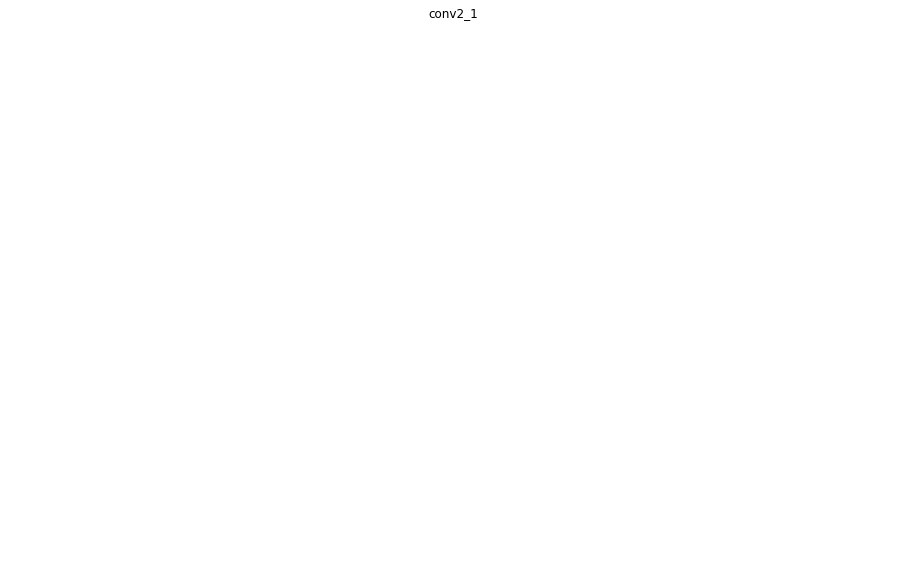

In [62]:
g_ascent.visualize(conv2_1, conv2_1_filters, title='conv2_1');

In [0]:
conv1_2 = model.layer1[0]
conv1_2_filters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

conv2_1 = model.layer2[0]
conv2_1_filters = [0, 1, 2, 3, 4]

In [0]:
g_ascent = GradientAscent(model.layer1)

g_ascent.use_gpu = True

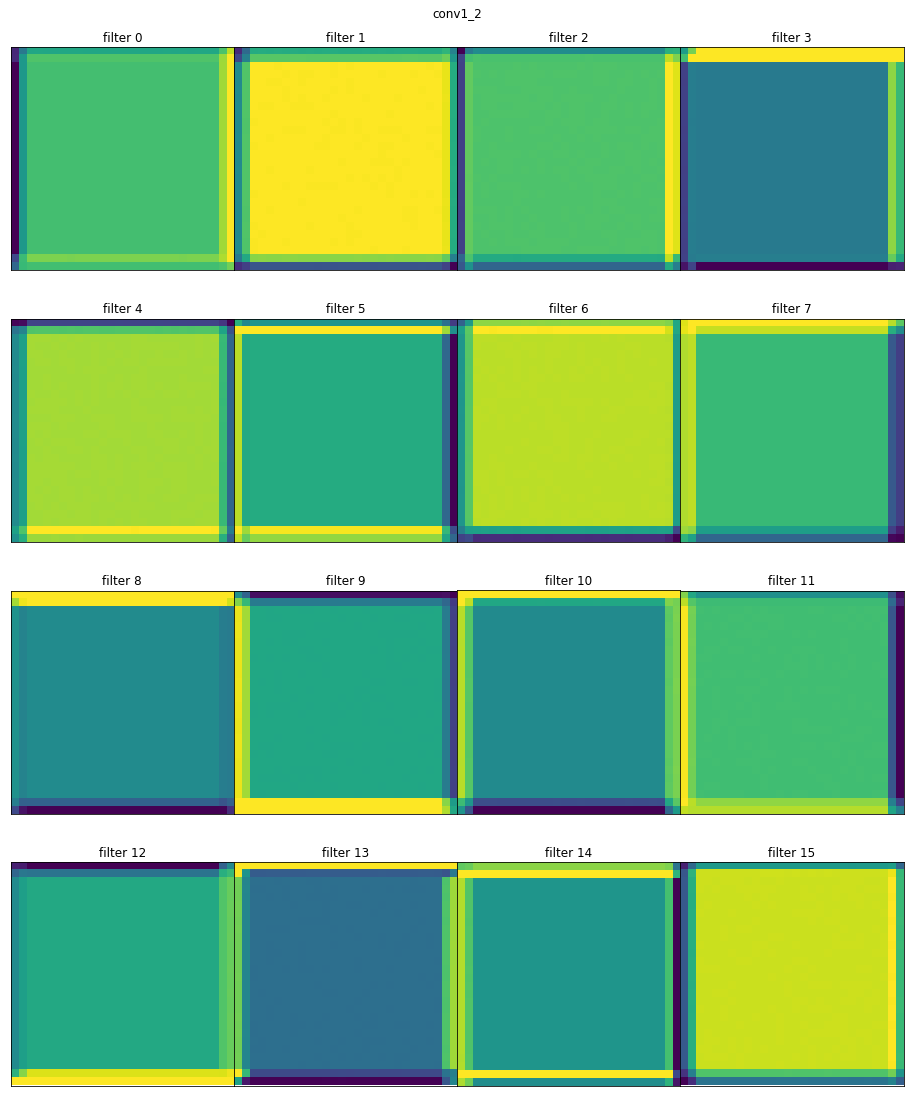

In [67]:
g_ascent.visualize(conv1_2, conv1_2_filters, title='conv1_2');